Because of the sheer size of the training dataset, I couldn't load it into a dataframe without the kernel crashing.

So, I took the first 5 million rows and used that as the dataset instead. Better than nothing.

In [1]:
import pandas as pd
import torch

# I read the data in the form of a single chunk since trying to load the whole dataset crashed the environment
chunk = pd.read_csv("train.csv", chunksize=5_000_000)
train = next(chunk)

Iterating over every column in the dataframe and removing rows where one of the column values have a low count in the dataset overall.

I check if the dataframe was actually changed (values were removed) then loop over again to see if there are new values that now have a low count and thus should now be removed as well.

In [2]:
train = train.drop(columns=['id', 'hour', 'device_id', 'device_ip', 'device_model'])


In [3]:
changed = True
while changed:
    changed = False
    size = 0
    for col in train:
        size = len(train)
        train = train[train.groupby(col)[col].transform(len) > 5000]
    if len(train) != size:
        changed = True

In [4]:
# Manually removed these columns since either I figured they weren't as important and would likely just take longer to run, or
# because they messed up my following processing step
train = train.drop(columns=['id', 'hour', 'device_id', 'device_ip', 'device_model'])

# Iterate over every column and group by values. Remove values where the count < 5,000 (0.1% of data) since they aren't going
# to get much value in the model with such low counts
for col in train:
    train = train[train.groupby(col)[col].transform(len) > 5000]

KeyError: "['id', 'hour', 'device_id', 'device_ip', 'device_model'] not found in axis"

In [5]:
# This encodes all strings in the dataset to integers
for col in train:
    train[col], filler = pd.factorize(train[col])

In [6]:
# convert to floats
train = train.astype(float)

# Make a dataframe consisting of only the weight columns
data = train[train.columns[~train.columns.isin(["click"])]]

# Make a dataframe consisting of only the outcome column
click = train["click"]

# standardize data (not the target / click data) around mean 0
data.iloc[:, 0:-1] = data.iloc[:, 0:-1].apply(
    lambda x: (x - x.mean()) / x.std(), axis=0
)

# convert to tensors and split to training and testing data
data = torch.tensor(data[:].values)
training_x = data[1_250_000:]
test_x = data[:1_250_000]

click = torch.tensor(click[:].values)
training_y = click[1_250_000:]
test_y = click[:1_250_000]

In [39]:
# Pretty self explanitory. The sigmoid function.
def sigmoid(z):
    return 1 / (1 + torch.exp(torch.tensor(-z)))

In [40]:
# Apply the sigmoid function to every element in a tensor and return it
def sigall(x):
    return torch.tensor([sigmoid(value) for value in x])

In [41]:
# Get the cross entropy loss given a phat and p
def getloss(y_pred, y_true):
    return -torch.mean(
        y_true * torch.log(y_pred + 1e-9) + (1 - y_true) * torch.log(1 - y_pred + 1e-9)
    )

In [46]:
# Get the gradient for each weight and the bias
def updateGradients(x, y_pred, y_true):
    diff = y_pred - y_true
    g_bias = torch.mean(diff)
    g_weights = torch.matmul(torch.transpose(x, 0, 1), diff)
    g_weights = torch.Tensor([torch.mean(grad) for grad in g_weights])

    return g_weights, g_bias

In [64]:
def sgd(x_train, y_train, learning_rate=0.1, n_iterations=100, batch_size=9999):
    totalLoss = []
    weights = torch.rand(train.shape[1] - 1)
    weights = weights.double()
    bias = 0.0

    for _ in range(n_iterations):
        # Batches for stochastic gradient descent
        # Shuffles the order of the full datasets, then picks batch_size# of them
        inds = torch.randperm(x_train.size()[0])
        x = x_train[inds][:batch_size]
        y = y_train[inds][:batch_size]

        # Multiply the weights by the actual values in the row, then add the bias to get values
        x_dot_weights = torch.matmul(weights, torch.transpose(x, 0, 1)) + bias

        # Apply sigmoid function to those values and get predictions
        pred = sigall(x_dot_weights)

        # Get loss of the predictions
        totalLoss.append(getloss(pred, y))

        # Get gradients of weight and bias given the prediction and true value
        w_grad, b_grad = updateGradients(x, pred, y)

        # Update weights and bias
        weights -= learning_rate * w_grad
        bias -= learning_rate * b_grad


    return weights, bias, totalLoss

In [75]:
weights, bias, totalLoss = sgd(training_x, training_y, 0.0001, 100, 1000)

/tmp/ipykernel_21177/1300567015.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 1 / (1 + torch.exp(torch.tensor(-z)))


Text(0.5, 1.0, 'Loss')

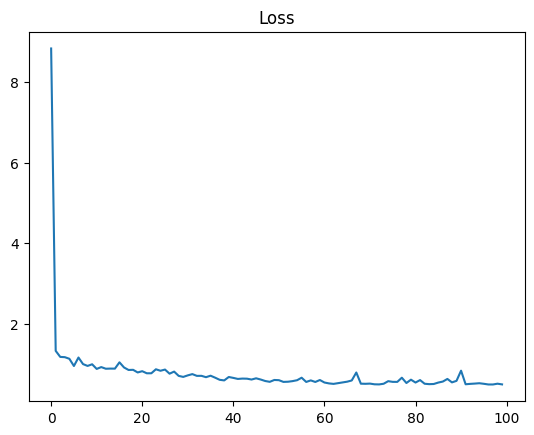

In [76]:
import matplotlib.pyplot as plt
plt.plot(range(len(totalLoss)), totalLoss)
plt.title("Loss")

In [77]:
def predict(x, weights, bias, threshhold=0.5):
    x_dot_weights = torch.matmul(weights, torch.transpose(x, 0, 1)) + bias
    predictions = sigall(x_dot_weights)
    print(predictions)
    return [1 if p >= threshhold else 0 for p in predictions]

In [78]:
def getPrecRecall(y_pred, y_true):
    TP, FP, FN = 0, 0, 0
    for p, t in zip(y_pred, y_true):
        if p == t == 1:
            TP += 1
        elif p==1 and t==0:
            FP += 1
        elif p==0 and t==1:
            FN += 1

    try:
        precision = TP / (TP + FP)
    except:
        precision = 1

    try:
        recall = TP / (TP + FN)
    except:
        precision = 1

    return precision, recall

In [81]:
threshholds = torch.tensor([0, 0.1, 0.2, 1])
precision, recall = [], []
for t in threshholds:
    test_pred = predict(test_x, weights, bias, t)
    p, r = getPrecRecall(test_pred, test_y)
    precision.append(p)
    recall.append(r)

/tmp/ipykernel_21177/1300567015.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 1 / (1 + torch.exp(torch.tensor(-z)))


tensor([0.2069, 0.2409, 0.2409,  ..., 0.2051, 0.2494, 0.1705],
       dtype=torch.float64)
tensor([0.2069, 0.2409, 0.2409,  ..., 0.2051, 0.2494, 0.1705],
       dtype=torch.float64)
tensor([0.2069, 0.2409, 0.2409,  ..., 0.2051, 0.2494, 0.1705],
       dtype=torch.float64)
tensor([0.2069, 0.2409, 0.2409,  ..., 0.2051, 0.2494, 0.1705],
       dtype=torch.float64)


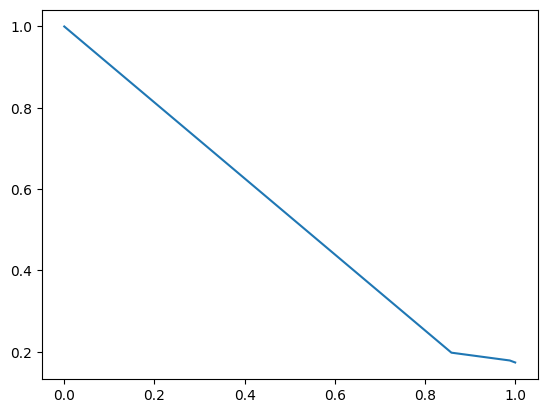

In [82]:
plt.plot(recall, precision)

While my curve isn't exactly... curvy... I do at least understand what it's *supposed* to look like.

Essentially, precision (the y-axis) is the ratio between the detected positive outcomes that were *actually* positive and the number of *all* outcomes that were *predicted* to pe positive.

Recall is the ratio between the number of positive outcomes that were *actually* positive and the number of actually positive outcomes across the entire set.

The curve is supposed to show the natural consequences that happen when one of the two properties are maximized. When precision is very high (the model only predicts positve outcomes if it is *absolutely certain*) it misses a lot of other values that were positive, but it wasn't 100% certain about. So, the resulting recall is low.

On the other hand, when recall is maximized, a model tends to just accept every outcome as positive even when they might not be. It's very generous with it's classification, so it also lets a lot of false outcomes pass as positive. This means a high false positive rate, and a precision value that is very low.